[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/simple-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238187-lesson-2-simple-graph)

# 简单的图

让我们构建一个包含 3 个节点和一个条件边的简单图

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## 状态

首先，定义图的[状态](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)。

状态结构是图中所有节点和边的输入结构。

让我们使用python的`typing`模块中的`TypedDict`类作为我们的结构，它为键提供类型提示

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## 节点

[节点](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes)只是 Python 函数。

第一个位置参数是状态（如上面所定义）。

因为状态是具有如上定义的结构的`TypedDict`结构，所以每个节点都可以通过`state['graph_state']`访问状态的键`graph_state`。

每个节点返回状态键`graph_state`的新值。
  
默认情况下，每个节点返回的新值[将覆盖](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) 先前的状态值。

In [2]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

## 边

[边](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges)连接节点。

普通的边被用于当你想*始终固定*从一个节点出发到另一个节点的时候，例如从`node_1`到`node_2`。

[条件边](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)被用于当你想*可选择的*在两个节点间路由的时候
 
条件边被实现为根据某些逻辑返回要访问的下一个节点的函数。

In [3]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

## 图构建

现在，我们根据上面定义的[组件](https://langchain-ai.github.io/langgraph/concepts/low_level/)来构建图

[StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph)类是我们可用的图类。
 
首先，我们使用上面定义的`State`类初始化一个StateGraph。
 
然后，我们添加我们的节点和边。

我们使用[`START`节点，一个特殊节点](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node)可以将用户输入发送到图中, 来指示我们的图从哪里起始。
 
[`END` 节点](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node)是一个表示终止节点的特殊节点。

最后，我们[编译我们的图](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph)对图结构进行一些基本检查。

我们可以将图可视化为一个[Mermaid 图表](https://github.com/mermaid-js/mermaid).

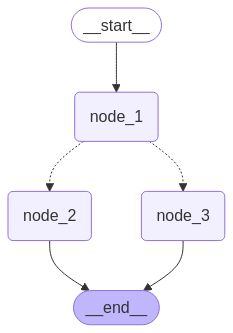

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## 图调用

编译好的图实现了[runnable](https://python.langchain.com/docs/concepts/runnables/)协议.

这为执行 LangChain 组件提供了一个标准方式。
 
`invoke`是该接口中的标准方法之一。

输入是一个字典 `{"graph_state": "Hi, this is lance."}`，用于设置我们图状态（`State`）字典的初始值。

当`invoke`被调用时，图从`START`节点开始执行。

它按顺序(`node_1`, `node_2`, `node_3`)通过之前定义的节点

条件边将根据 50/50 决策规则从节点`1`通过节点`2`或`3`。

每个节点函数接收当前状态并返回一个新值，该值覆盖图状态。

执行将继续，直到达到`END`节点。

In [9]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Lance. I am happy!'}

`invoke`同步的运行整个图

就是等待每个步骤完成后再进行下一步。

它返回所有节点执行完毕后的图最终状态。

在这个例子中，它返回`node_3`完成后的状态：

```
{'graph_state': 'Hi, this is Lance. I am happy!'}
```
或（50%）

```
{'graph_state': 'Hi, this is Lance. I am sad!'}
```